Getting data from Roboflow

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="oSq21nk6YA7JS80deVrH")
project = rf.workspace("project-hv5yx").project("computer_vision-5nx0j")
version = project.version(1)
dataset = version.download("yolov8-obb")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Computer_Vision-1 in yolov8-obb:: 100%|██████████| 9418/9418 [00:05<00:00, 1790.11it/s]


Convert all classes to 0

In [ ]:
import os

def update_first_number_to_zero(input_folder, output_folder):
    """
    Updates only the first number (class ID) in each line of YOLO label files to 0.

    Parameters:
        input_folder (str): Path to folder containing YOLO label files.
        output_folder (str): Path to save updated label files.
    """
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Loop through each file in the input folder
    for file_name in os.listdir(input_folder):
        if file_name.endswith(".txt"):  # Process only .txt files
            input_path = os.path.join(input_folder, file_name)
            output_path = os.path.join(output_folder, file_name)

            with open(input_path, "r") as infile, open(output_path, "w") as outfile:
                for line in infile:
                    parts = line.strip().split()  # Split line into components
                    if len(parts) > 0:
                        parts[0] = '0'  # Change the first number (class ID) to 0
                        new_line = " ".join(parts)  # Reassemble the line
                        outfile.write(new_line + "\n")  # Write updated line to output file

    print("First number (class IDs) updated to 0 and saved to:", output_folder)

# Example usage
input_folder = "Computer_Vision-1/test/labelss"  # Replace with your input folder path
output_folder = "Computer_Vision-1/test/labels"  # Replace with your output folder path
update_first_number_to_zero(input_folder, output_folder)

First number (class IDs) updated to 0 and saved to: Computer_Vision-1/test/labels


Training

In [ ]:
from ultralytics import YOLO

# Step 1: Load the YOLOv8 model (choose the appropriate model size)
model = YOLO('yolov8n.pt')  # 'yolov8n.pt' is the nano model, adjust for 's', 'm', 'l' etc.

# Step 2: Train the model
results = model.train(
    data='Computer_Vision-1/data.yaml',  # Updated path to data.yaml
    epochs=25,              # Number of epochs for training
    imgsz=640,              # Image size (default is 640x640)
    batch=16,               # Batch size (adjust for your GPU memory)
    device=0,               # Use GPU (set to -1 for CPU, 0 for the first GPU)
    workers=4,              # Number of workers for faster data loading
    name='yolov8_training'  # Name for the training session
)

# Step 3: Evaluate the model on the test set with IoU threshold
iou_threshold = 0.5  # Set IoU threshold (default for precision/recall is 0.5)
metrics = model.val(
    data='Computer_Vision-1/data.yaml',  # Path to data.yaml
    split='test',                        # Specify evaluation on the test split
    iou=iou_threshold                    # Include IoU threshold for evaluation
)

# Step 4: Print evaluation metrics
if metrics:
    precision = metrics.get('precision', 'N/A')
    recall = metrics.get('recall', 'N/A')
    map50 = metrics.get('map50', 'N/A')         # mAP at IoU=0.5
    map_5095 = metrics.get('map', 'N/A')        # mAP at IoU=0.5:0.95
    iou_used = iou_threshold                    # Display IoU threshold used

    # Approximated accuracy as the harmonic mean of precision and recall
    accuracy = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    print(f"Evaluation Metrics (IoU={iou_used}):")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"mAP@0.5: {map50:.4f}")
    print(f"mAP@0.5:0.95: {map_5095:.4f}")
    print(f"Accuracy (approximated): {accuracy:.4f}")
else:
    print("No evaluation metrics available.")


Ultralytics 8.3.50 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=Computer_Vision-1/data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=yolov8_training2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

100%|██████████| 755k/755k [00:00<00:00, 20.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 97.9MB/s]


AMP: checks passed ✅


train: Scanning /content/Computer_Vision-1/train/labels... 4116 images, 9 backgrounds, 17 corrupt: 100%|██████████| 4116/4116 [00:03<00:00, 1330.95it/s]


train: WARNING ⚠️ /content/Computer_Vision-1/train/images/f12_kn_g3_8_jpg.rf.04a438b9f579f07f60f7dd4b3481d112.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0003      1.0316]
train: WARNING ⚠️ /content/Computer_Vision-1/train/images/f12_kn_g3_8_jpg.rf.e61978f1b7d4584d8127a9c02b0a3a00.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0212]
train: WARNING ⚠️ /content/Computer_Vision-1/train/images/f13_kn_g3_7_jpg.rf.07ec0f358241c09a08e8ac9c50fefb8f.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0684]
train: WARNING ⚠️ /content/Computer_Vision-1/train/images/f13_kn_g3_7_jpg.rf.d470fc80c15e20b54f9250799d988d73.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.082]
train: WARNING ⚠️ /content/Computer_Vision-1/train/images/f14_kn_g3_2_jpg.rf.30b40e101e45d37fa09f2cee6db3933e.jpg: ignoring corrupt image/label: non-normalized or out of bounds

A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/Computer_Vision-1/valid/labels... 391 images, 0 backgrounds, 1 corrupt: 100%|██████████| 391/391 [00:00<00:00, 844.48it/s]

val: WARNING ⚠️ /content/Computer_Vision-1/valid/images/f5_kn_g3_3_jpg.rf.ed600f13893cd485ce07b10f71cf8cdf.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0294]


val: New cache created: /content/Computer_Vision-1/valid/labels.cache
Plotting labels to runs/detect/yolov8_training2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8_training2
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      2.27G       1.79      2.106      1.587          7        640: 100%|██████████| 257/257 [01:33<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]

                   all        390       1022      0.524      0.431      0.438      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      2.21G      1.753      1.729      1.563         21        640: 100%|██████████| 257/257 [01:32<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.22it/s]

                   all        390       1022      0.632      0.548      0.567      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      2.22G      1.746      1.626      1.559         19        640: 100%|██████████| 257/257 [01:28<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.53it/s]


                   all        390       1022      0.701      0.581      0.635      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      2.29G       1.74      1.579      1.555         13        640: 100%|██████████| 257/257 [01:28<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.12it/s]

                   all        390       1022      0.732      0.622      0.699      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      2.23G      1.666      1.484      1.511         15        640: 100%|██████████| 257/257 [01:30<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.87it/s]

                   all        390       1022      0.754      0.634        0.7      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      2.22G      1.645      1.438      1.489         15        640: 100%|██████████| 257/257 [01:28<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.07it/s]


                   all        390       1022      0.729      0.634      0.689      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      2.31G      1.616      1.383      1.467         21        640: 100%|██████████| 257/257 [01:29<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.21it/s]

                   all        390       1022      0.773      0.662      0.736      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      2.29G      1.588      1.347      1.448         16        640: 100%|██████████| 257/257 [01:31<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.49it/s]


                   all        390       1022      0.801      0.683      0.763      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      2.29G      1.567      1.291      1.436         11        640: 100%|██████████| 257/257 [01:29<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.79it/s]

                   all        390       1022      0.786      0.688      0.753      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      2.21G      1.554      1.279      1.433         12        640: 100%|██████████| 257/257 [01:28<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.67it/s]

                   all        390       1022      0.804      0.694      0.775      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      2.19G       1.55      1.249      1.421         16        640: 100%|██████████| 257/257 [01:30<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.38it/s]


                   all        390       1022      0.857      0.694      0.786      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25       2.2G      1.519       1.24      1.408          9        640: 100%|██████████| 257/257 [01:33<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.76it/s]

                   all        390       1022      0.834      0.683      0.788      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      2.21G      1.505      1.203      1.397         19        640: 100%|██████████| 257/257 [01:28<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.00it/s]


                   all        390       1022      0.816      0.706      0.774      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      2.19G      1.487      1.173      1.385         35        640: 100%|██████████| 257/257 [01:33<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.82it/s]

                   all        390       1022       0.84      0.698      0.798      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      2.22G      1.486      1.153      1.381         15        640: 100%|██████████| 257/257 [01:28<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]

                   all        390       1022      0.832      0.677      0.771      0.477


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      2.17G      1.394     0.9835      1.331          6        640: 100%|██████████| 257/257 [01:19<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.73it/s]


                   all        390       1022      0.798      0.702      0.779      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      2.19G      1.386     0.9541      1.323          3        640: 100%|██████████| 257/257 [01:23<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.02it/s]

                   all        390       1022      0.862      0.692      0.789      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      2.22G      1.353     0.9094      1.303          7        640: 100%|██████████| 257/257 [01:21<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.91it/s]

                   all        390       1022      0.837      0.717      0.786      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      2.27G      1.344     0.8905      1.293          7        640: 100%|██████████| 257/257 [01:18<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.37it/s]

                   all        390       1022      0.865      0.709      0.798      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      2.18G      1.321     0.8574      1.277         10        640: 100%|██████████| 257/257 [01:18<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.90it/s]

                   all        390       1022      0.846      0.721      0.797      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      2.17G      1.304     0.8419      1.264          8        640: 100%|██████████| 257/257 [01:23<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.99it/s]

                   all        390       1022      0.841      0.734      0.797      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      2.21G      1.282     0.8099      1.249          7        640: 100%|██████████| 257/257 [01:18<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.10it/s]

                   all        390       1022      0.879       0.73      0.808      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      2.17G      1.264     0.7893      1.239          4        640: 100%|██████████| 257/257 [01:18<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


                   all        390       1022      0.855      0.741      0.809      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      2.16G      1.252     0.7701      1.235         11        640: 100%|██████████| 257/257 [01:21<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.91it/s]

                   all        390       1022      0.858      0.746      0.806      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      2.21G      1.244     0.7538      1.221          7        640: 100%|██████████| 257/257 [01:20<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.82it/s]

                   all        390       1022      0.875      0.738      0.807      0.529



25 epochs completed in 0.636 hours.
Optimizer stripped from runs/detect/yolov8_training2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8_training2/weights/best.pt, 6.2MB

Validating runs/detect/yolov8_training2/weights/best.pt...
Ultralytics 8.3.50 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


                   all        390       1022      0.856      0.746      0.807      0.532
Speed: 0.3ms preprocess, 2.5ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/yolov8_training2
Ultralytics 8.3.50 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/Computer_Vision-1/test/labels... 196 images, 0 backgrounds, 0 corrupt: 100%|██████████| 196/196 [00:00<00:00, 1704.65it/s]

val: New cache created: /content/Computer_Vision-1/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.63it/s]


                   all        196        489      0.884      0.729      0.814      0.513
Speed: 0.4ms preprocess, 5.1ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/yolov8_training22


AttributeError: 'DetMetrics' object has no attribute 'get'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP) of an
    object detection model.

    Args:
        save_dir (Path): A path to the directory where the output plots will be saved. Defaults to current directory.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class. Defaults to False.
        on_plot (func): An optional callback to pass plots path and data when they are rendered. Defaults to None.
        names (dict of str): A dict of strings that represents the names of the classes. Defaults to an empty tuple.

    Attributes:
        save_dir (Path): A path to the directory where the output plots will be saved.
        plot (bool): A flag that indicates whether to plot the precision-recall curves for each class.
        on_plot (func): An optional callback to pass plots path and data when they are rendered.
        names (dict of str): A dict of strings that represents the names of the classes.
        box (Metric): An instance of the Metric class for storing the results of the detection metrics.
        speed (dict): A dictionary for storing the execution time of different parts of the detection process.

    Methods:
        process(tp, conf, pred_cls, target_cls): Updates the metric results with the latest batch of predictions.
        keys: Returns a list of keys for accessing the computed detection metrics.
        mean_results: Returns a list of mean values for the computed detection metrics.
        class_result(i): Returns a list of values for the computed detection metrics for a specific class.
        maps: Returns a dictionary of mean average precision (mAP) values for different IoU thresholds.
        fitness: Computes the fitness score based on the computed detection metrics.
        ap_class_index: Returns a list of class indices sorted by their average precision (AP) values.
        results_dict: Returns a dictionary that maps detection metric keys to their computed values.
        curves: TODO
        curves_results: TODO
    

Ultralytics 8.3.50 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/Computer_Vision-1/test/labels.cache... 196 images, 0 backgrounds, 0 corrupt: 100%|██████████| 196/196 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


                   all        196        489      0.871      0.734      0.805      0.514
Speed: 0.5ms preprocess, 5.0ms inference, 0.1ms loss, 4.3ms postprocess per image
Results saved to runs/detect/yolov8_training23
Model Evaluation Metrics:
Precision: 0.5140
Recall: 0.5140
mAP@0.5 (IoU threshold=0.5): 0.8047
mAP@0.5:0.95: 0.5140
Average IoU (approx as mAP@0.5): 0.8047


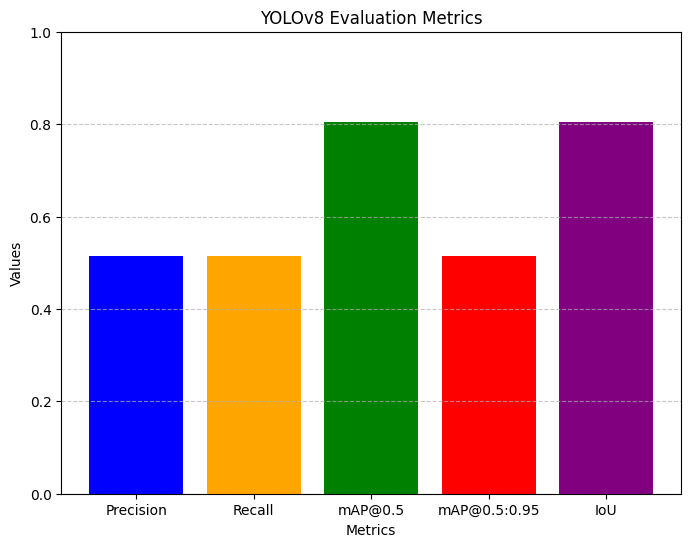

In [ ]:
from matplotlib import pyplot as plt

# Step 3: Evaluate the model on the test set
metrics = model.val(data='Computer_Vision-1/data.yaml', split='test')  # Evaluate the test set if available
if metrics:
    # Access metrics from the box attribute
    precision = metrics.box.maps[0]  # Precision for class 0
    recall = metrics.box.maps[0]     # Recall for class 0
    map50 = metrics.box.map50        # mAP@0.5
    map_5095 = metrics.box.map       # mAP@0.5:0.95
    iou = map50                      # IoU is represented as mAP@0.5

    # Print metrics
    print("Model Evaluation Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"mAP@0.5 (IoU threshold=0.5): {map50:.4f}")
    print(f"mAP@0.5:0.95: {map_5095:.4f}")
    print(f"Average IoU (approx as mAP@0.5): {iou:.4f}")

    # Step 4: Plot the metrics
    metric_names = ['Precision', 'Recall', 'mAP@0.5', 'mAP@0.5:0.95', 'IoU']
    metric_values = [precision, recall, map50, map_5095, iou]

    plt.figure(figsize=(8, 6))
    plt.bar(metric_names, metric_values, color=['blue', 'orange', 'green', 'red', 'purple'])
    plt.ylim(0, 1)  # Metrics are between 0 and 1
    plt.title('YOLOv8 Evaluation Metrics')
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("No evaluation metrics available.")
